# Multi-Resolution Dataset Validation

This notebook validates the multi-resolution training pipeline:
1. ImageProcessor with multi-resolution configuration
2. ImageDataset loading and preprocessing
3. Collate function behavior
4. DataLoader functionality

Based on config: `tests/test_configs/test_example_fluxkontext_fp16_multiresolution.yaml`


In [1]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import logging

# Configure logging
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

# Add project root to path
project_root = Path.cwd()
project_root = project_root.parent.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Project root: /mnt/nas/public2/lilong/repos/qwen-image-finetune
Python version: 3.12.11 | packaged by conda-forge | (main, Jun  4 2025, 14:45:31) [GCC 13.3.0]
PyTorch version: 2.5.1+cu121
CUDA available: True


## 1. Load Configuration


In [2]:
from src.data.config import load_config_from_yaml

# Load config
config_path = "../../tests/test_configs/test_example_fluxkontext_fp16_multiresolution.yaml"
config = load_config_from_yaml(config_path)

print("\n=== Configuration Loaded ===")
print(f"Config file: {config_path}")
print(f"\nData config:")
print(f"  Dataset: {config.data.init_args.dataset_path}")
print(f"  Batch size: {config.data.batch_size}")
print(f"  Num workers: {config.data.num_workers}")
print(f"\nProcessor config:")
processor_config = config.data.init_args.processor.init_args
print(f"  Process type: {processor_config.process_type}")
print(f"  Resize mode: {processor_config.resize_mode}")
print(f"  Multi-resolutions: {processor_config.multi_resolutions}")
print(f"  Max aspect ratio: {processor_config.max_aspect_ratio}")


/home/lilong/.local/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
10/11/2025 13:05:29 - WARNING - huggingface_hub._login - Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.



=== Configuration Loaded ===
Config file: ../../tests/test_configs/test_example_fluxkontext_fp16_multiresolution.yaml

Data config:
  Dataset: [{'split': 'train', 'repo_id': 'TsienDragon/face_segmentation_20'}]
  Batch size: 2
  Num workers: 2

Processor config:
  Process type: fixed_pixels
  Resize mode: bilinear
  Multi-resolutions: [262144, 295936, 313344, 350208, 368640, 408576, 428032, 471040, 491520, 512000, 1228800, 1048576, 1394688]
  Max aspect ratio: 3.0


## 2. Test ImageProcessor

Test the processor with various image sizes to verify multi-resolution selection logic.


In [3]:
from src.data.preprocess import ImageProcessor
from PIL import Image

# Initialize processor
processor = ImageProcessor(processor_config)

print("\n=== ImageProcessor Initialized ===")
print(f"Multi-resolutions (pixels): {processor.multi_resolutions}")
print(f"Max aspect ratio: {processor.max_aspect_ratio}")

# Test with various image sizes
test_sizes = [
    (400, 400),   # Close to 512*512
    (600, 600),   # Close to 640*640
    (800, 400),   # Close to 768*512
    (900, 500),   # Close to 832*576
    (1024, 768),  # Larger image
    (300, 900),   # High aspect ratio
]

print("\n=== Testing Multi-Resolution Selection ===")
for orig_w, orig_h in test_sizes:
    # Create dummy image
    dummy_image = np.random.randint(0, 255, (orig_h, orig_w, 3), dtype=np.uint8)

    # Select best resolution
    best_pixels = processor._select_pixels_candidate(orig_w, orig_h)

    # Get target dimensions
    from src.data.preprocess import best_hw_given_area
    new_w, new_h = best_hw_given_area(best_pixels, orig_w, orig_h, step=16)

    orig_ratio = orig_w / orig_h
    new_ratio = new_w / new_h

    print(f"\nOriginal: {orig_w}x{orig_h} ({orig_w*orig_h:,} pixels, ratio={orig_ratio:.2f})")
    print(f"  → Selected: {new_w}x{new_h} ({new_w*new_h:,} pixels, ratio={new_ratio:.2f})")
    print(f"  → Candidate pixels: {best_pixels:,}")
    print(f"  → Area change: {(new_w*new_h - orig_w*orig_h) / (orig_w*orig_h) * 100:+.1f}%")


10/11/2025 13:05:30 - INFO - root - ImageProcessor initialized with target_size: Nonecontrols_size: Nonetarget_pixels: Nonecontrols_pixels: None



=== ImageProcessor Initialized ===
Multi-resolutions (pixels): [262144, 295936, 313344, 350208, 368640, 408576, 428032, 471040, 491520, 512000, 1228800, 1048576, 1394688]
Max aspect ratio: 3.0

=== Testing Multi-Resolution Selection ===

Original: 400x400 (160,000 pixels, ratio=1.00)
  → Selected: 512x512 (262,144 pixels, ratio=1.00)
  → Candidate pixels: 262,144
  → Area change: +63.8%

Original: 600x600 (360,000 pixels, ratio=1.00)
  → Selected: 576x640 (368,640 pixels, ratio=0.90)
  → Candidate pixels: 368,640
  → Area change: +2.4%

Original: 800x400 (320,000 pixels, ratio=2.00)
  → Selected: 816x384 (313,344 pixels, ratio=2.12)
  → Candidate pixels: 313,344
  → Area change: -2.1%

Original: 900x500 (450,000 pixels, ratio=1.80)
  → Selected: 736x640 (471,040 pixels, ratio=1.15)
  → Candidate pixels: 471,040
  → Area change: +4.7%

Original: 1024x768 (786,432 pixels, ratio=1.33)
  → Selected: 1024x1024 (1,048,576 pixels, ratio=1.00)
  → Candidate pixels: 1,048,576
  → Area change: 

## 3. Test Dataset Loading

Load the dataset and inspect individual samples.


In [ ]:
from src.data.dataset import ImageDataset
import random

# Create dataset
dataset = ImageDataset(config.data.init_args)
print("\n=== Dataset Loaded ===")
print(f"Total samples: {len(dataset)}")
print(f"Dataset paths: {dataset.dataset_paths}")
print(f"Cache enabled: {dataset.use_cache}")
print(f"Cache exists: {dataset.cache_exists}")

In [7]:


# Load first few samples
print("\n=== Sample Inspection ===")
num_samples_to_check = min(3, len(dataset))

for idx in range(num_samples_to_check):
    idx = random.randint(0, len(dataset) - 1)
    sample = dataset[idx]
    print(f"\n--- Sample {idx} ---")
    print(f"Keys: {list(sample.keys())}")

    if 'image' in sample:
        img_shape = sample['image'].shape
        print(f"Image shape: {img_shape} (C, H, W)")

    if 'control' in sample:
        ctrl_shape = sample['control'].shape
        print(f"Control shape: {ctrl_shape} (C, H, W)")

    if 'mask' in sample:
        mask_shape = sample['mask'].shape
        print(f"Mask shape: {mask_shape}")

    if 'img_shapes' in sample:
        print(f"Image shapes (original): {sample['img_shapes']}")

    if 'prompt' in sample:
        prompt_text = sample['prompt'][:100] if isinstance(sample['prompt'], str) else str(sample['prompt'])
        print(f"Prompt: {prompt_text}...")

    print(f"Cached: {sample.get('cached', False)}")
    print(f"N controls: {sample.get('n_controls', 0)}")



=== Sample Inspection ===
data (960, 1280) (960, 1280)

--- Sample 11 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'n_controls']
Image shape: torch.Size([3, 1280, 960]) (C, H, W)
Control shape: torch.Size([3, 1280, 960]) (C, H, W)
Image shapes (original): [(3, 1280, 960), (3, 1280, 960)]
Prompt: change the image from the face to the face segmentation mask...
Cached: False
N controls: 0
data (1024, 1365) (768, 1024)

--- Sample 7 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'n_controls']
Image shape: torch.Size([3, 1376, 1024]) (C, H, W)
Control shape: torch.Size([3, 1376, 1024]) (C, H, W)
Image shapes (original): [(3, 1376, 1024), (3, 1376, 1024)]
Prompt: change the image from the face to the face segmentation mask...
Cached: False
N controls: 0
data (1024, 1365) (1024, 1365)

--- Sample 19 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'n_controls']
Image shape: torch.Size([3, 1376,

## 4. Visualize Sample Images

Visualize the processed images to verify resizing works correctly.


data (1024, 1365) (768, 1024)


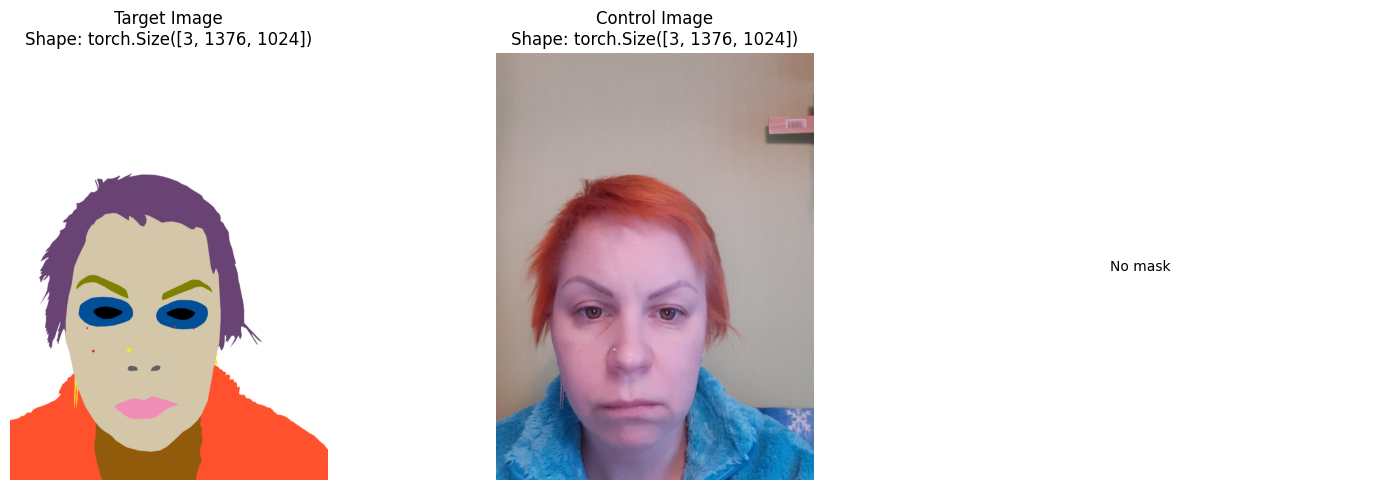


Image shapes in original space: [(3, 1376, 1024), (3, 1376, 1024)]


In [5]:
def tensor_to_image(tensor):
    """Convert (C, H, W) tensor in [0, 1] to numpy array for visualization"""
    if isinstance(tensor, torch.Tensor):
        img = tensor.permute(1, 2, 0).cpu().numpy()
    else:
        img = tensor
    img = np.clip(img, 0, 1)
    return img

# Visualize first sample
if len(dataset) > 0:
    sample = dataset[17]

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Image
    if 'image' in sample:
        img = tensor_to_image(sample['image'])
        axes[0].imshow(img)
        axes[0].set_title(f"Target Image\nShape: {sample['image'].shape}")
        axes[0].axis('off')

    # Control
    if 'control' in sample:
        ctrl = tensor_to_image(sample['control'])
        axes[1].imshow(ctrl)
        axes[1].set_title(f"Control Image\nShape: {sample['control'].shape}")
        axes[1].axis('off')

    # Mask
    if 'mask' in sample:
        mask = sample['mask'].cpu().numpy() if isinstance(sample['mask'], torch.Tensor) else sample['mask']
        if mask.ndim == 3:
            mask = mask[0]  # Take first channel
        axes[2].imshow(mask, cmap='gray')
        axes[2].set_title(f"Mask\nShape: {sample['mask'].shape}")
        axes[2].axis('off')
    else:
        axes[2].text(0.5, 0.5, 'No mask', ha='center', va='center')
        axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    print(f"\nImage shapes in original space: {sample.get('img_shapes', [])}")


## 5. Test Collate Function

Test the collate function with samples of different resolutions.


In [9]:
from src.data.dataset import collate_fn


In [ ]:
import torch
latents = [
    torch.randn(2, 4),
    torch.randn(4, 4),
]
batch = ({
    'image': [torch.randn(3, 8, 8), torch.randn(3, 4, 4)],
    'latents': latents,
    'img_shapes': [(3, 12, 12), (3, 8, 16)],
    'prompt': ['test', 'done'],
})
# convert to list of dicts
batch = [ {k: v[i] for k, v in batch.items()} for i in range(2)]

In [14]:
batch

[{'image': tensor([[ 0.3856,  0.1931,  0.5532,  ...,  0.7350,  0.7320,  1.0862],
          [ 0.8814,  1.2093,  1.2398,  ...,  2.0771,  0.3150, -0.8360],
          [-0.2905,  0.0952, -0.0326,  ..., -0.2281, -1.5209, -0.7855],
          ...,
          [ 0.6946, -2.1987, -1.3693,  ..., -0.6378, -0.0946, -1.0086],
          [-0.2502,  0.8786,  0.8663,  ...,  0.0624, -1.0442, -0.0087],
          [-0.4545,  1.8392, -0.5502,  ...,  0.2224, -0.9829,  0.2745]]),
  'latents': tensor([[-1.6767,  0.8136,  1.6676,  ...,  0.6684,  1.5000,  0.3195],
          [-1.1196,  1.1598, -0.1060,  ..., -0.1900,  0.4084, -0.5563],
          [-0.2552, -0.4394,  1.8266,  ...,  0.2500, -0.0538,  0.7121],
          ...,
          [-0.8298, -0.4340,  0.8729,  ...,  0.0491, -1.1806,  0.4188],
          [-0.0751, -1.5230, -2.6038,  ..., -1.0650, -0.1522, -1.9760],
          [-0.1546,  0.1689,  1.0919,  ..., -0.9538, -0.0673,  0.5432]]),
  'img_shapes': (3, 512, 512),
  'prompt': 'test'},
 {'image': tensor([[ 0.3332, -

In [15]:
ollated_batch = collate_fn(batch)

In [16]:
ollated_batch

{'image': tensor([[[ 0.3856,  0.1931,  0.5532,  ...,  0.7350,  0.7320,  1.0862],
          [ 0.8814,  1.2093,  1.2398,  ...,  2.0771,  0.3150, -0.8360],
          [-0.2905,  0.0952, -0.0326,  ..., -0.2281, -1.5209, -0.7855],
          ...,
          [ 0.6946, -2.1987, -1.3693,  ..., -0.6378, -0.0946, -1.0086],
          [-0.2502,  0.8786,  0.8663,  ...,  0.0624, -1.0442, -0.0087],
          [-0.4545,  1.8392, -0.5502,  ...,  0.2224, -0.9829,  0.2745]],
 
         [[ 0.3332, -0.7700,  0.0459,  ..., -0.9596,  0.1095,  1.0870],
          [ 1.6927, -1.8782,  0.4694,  ...,  1.3045,  0.5947, -0.0068],
          [-0.3147,  0.6055,  0.3788,  ...,  0.3343,  0.7441, -0.9983],
          ...,
          [-1.1276,  1.9104, -0.6167,  ..., -0.8760, -1.1008,  0.4221],
          [ 0.4137, -0.2684,  0.6806,  ...,  0.1244, -1.6145,  0.2905],
          [-1.2365, -0.8050,  1.1552,  ...,  0.5857, -0.3688, -0.0623]]]),
 'latents': tensor([[[-1.6767,  0.8136,  1.6676,  ...,  0.6684,  1.5000,  0.3195],
        

In [ ]:

# Create a small batch manually
batch_size = 2
if len(dataset) >= batch_size:
    batch = [dataset[i] for i in range(batch_size)]

    print("\n=== Before Collation ===")
    for i, sample in enumerate(batch):
        print(f"\nSample {i}:")
        if 'image' in sample:
            print(f"  Image shape: {sample['image'].shape}")
        if 'control' in sample:
            print(f"  Control shape: {sample['control'].shape}")
        if 'img_shapes' in sample:
            print(f"  Img shapes: {sample['img_shapes']}")

    # Apply collate function
    collated_batch = collate_fn(batch)

    print("\n=== After Collation ===")
    print(f"Batch keys: {list(collated_batch.keys())}")

    for key, value in collated_batch.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: shape={value.shape}, dtype={value.dtype}")
        elif isinstance(value, list):
            print(f"  {key}: list of length {len(value)}")
            if len(value) > 0:
                print(f"    First item type: {type(value[0])}")
        else:
            print(f"  {key}: {type(value)}")

    # Check img_shapes structure
    if 'img_shapes' in collated_batch:
        print(f"\n  img_shapes detail:")
        for i, shapes in enumerate(collated_batch['img_shapes']):
            print(f"    Batch item {i}: {shapes}")


data (1024, 1365) (1024, 1365)
data (1024, 1365) (1024, 1365)

=== Before Collation ===

Sample 0:
  Image shape: torch.Size([3, 1376, 1024])
  Control shape: torch.Size([3, 1376, 1024])
  Img shapes: [(3, 1376, 1024), (3, 1376, 1024)]

Sample 1:
  Image shape: torch.Size([3, 1376, 1024])
  Control shape: torch.Size([3, 1376, 1024])
  Img shapes: [(3, 1376, 1024), (3, 1376, 1024)]

=== After Collation ===
Batch keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'n_controls']
  image: shape=torch.Size([2, 3, 1376, 1024]), dtype=torch.float32
  control: shape=torch.Size([2, 3, 1376, 1024]), dtype=torch.float32
  prompt: list of length 2
    First item type: <class 'str'>
  file_hashes: <class 'dict'>
  cached: list of length 2
    First item type: <class 'bool'>
  img_shapes: list of length 2
    First item type: <class 'list'>
  n_controls: list of length 2
    First item type: <class 'int'>

  img_shapes detail:
    Batch item 0: [(3, 1376, 1024), (3, 1376, 102

## 6. Test DataLoader

Test the full DataLoader with multiple workers and batching.


In [7]:
from torch.utils.data import DataLoader

# Create dataloader
dataloader = DataLoader(
    dataset,
    batch_size=config.data.batch_size,
    shuffle=config.data.shuffle,
    num_workers=min(config.data.num_workers, 0),  # Use 0 for notebook to avoid multiprocessing issues
    collate_fn=collate_fn,
    drop_last=False,
)

print("\n=== DataLoader Created ===")
print(f"Batch size: {config.data.batch_size}")
print(f"Num workers: 0 (notebook mode)")
print(f"Shuffle: {config.data.shuffle}")
print(f"Total batches: {len(dataloader)}")

# Iterate through a few batches
print("\n=== Testing DataLoader Iteration ===")
num_batches_to_test = min(3, len(dataloader))

for batch_idx, batch in enumerate(dataloader):
    if batch_idx >= num_batches_to_test:
        break

    print(f"\n--- Batch {batch_idx} ---")
    print(f"Keys: {list(batch.keys())}")

    for key, value in batch.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: {value.shape} ({value.dtype})")
        elif isinstance(value, list):
            print(f"  {key}: list[{len(value)}]")
            if len(value) > 0 and hasattr(value[0], 'shape'):
                print(f"    → items: {[v.shape if hasattr(v, 'shape') else type(v) for v in value]}")
        else:
            print(f"  {key}: {type(value)}")

    # Verify img_shapes
    if 'img_shapes' in batch:
        print(f"\n  Image shapes per batch item:")
        for i, shapes in enumerate(batch['img_shapes']):
            print(f"    Item {i}: {shapes}")

print("\n=== DataLoader Test Complete ===")



=== DataLoader Created ===
Batch size: 2
Num workers: 0 (notebook mode)
Shuffle: True
Total batches: 10

=== Testing DataLoader Iteration ===

--- Batch 0 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'n_controls']
  image: torch.Size([2, 3, 768, 624]) (torch.float32)
  control: torch.Size([2, 3, 768, 624]) (torch.float32)
  prompt: list[2]
  file_hashes: <class 'dict'>
  cached: list[2]
  img_shapes: list[2]
  n_controls: list[2]

  Image shapes per batch item:
    Item 0: [(3, 768, 624), (3, 768, 624)]
    Item 1: [(3, 768, 624), (3, 768, 624)]

--- Batch 1 ---
Keys: ['image', 'control', 'prompt', 'file_hashes', 'cached', 'img_shapes', 'n_controls']
  image: torch.Size([2, 3, 768, 624]) (torch.float32)
  control: torch.Size([2, 3, 768, 624]) (torch.float32)
  prompt: list[2]
  file_hashes: <class 'dict'>
  cached: list[2]
  img_shapes: list[2]
  n_controls: list[2]

  Image shapes per batch item:
    Item 0: [(3, 768, 624), (3, 768, 624)]
    Item 1

## 7. Multi-Resolution Statistics

Analyze the distribution of resolutions in the dataset.


In [8]:
from collections import Counter

# Collect resolution statistics
resolution_counter = Counter()
aspect_ratios = []

num_samples_to_analyze = min(20, len(dataset))

print("\n=== Analyzing Resolution Distribution ===")
print(f"Analyzing {num_samples_to_analyze} samples...\n")

for idx in range(num_samples_to_analyze):
    sample = dataset[idx]

    if 'image' in sample:
        _, h, w = sample['image'].shape
        resolution = (w, h)
        resolution_counter[resolution] += 1
        aspect_ratios.append(w / h)

print("Resolution distribution:")
for resolution, count in resolution_counter.most_common():
    w, h = resolution
    pixels = w * h
    ratio = w / h
    percentage = count / num_samples_to_analyze * 100
    print(f"  {w}x{h} ({pixels:,} pixels, ratio={ratio:.2f}): {count} samples ({percentage:.1f}%)")

if aspect_ratios:
    print(f"\nAspect ratio statistics:")
    print(f"  Min: {min(aspect_ratios):.2f}")
    print(f"  Max: {max(aspect_ratios):.2f}")
    print(f"  Mean: {np.mean(aspect_ratios):.2f}")
    print(f"  Std: {np.std(aspect_ratios):.2f}")



=== Analyzing Resolution Distribution ===
Analyzing 20 samples...

Resolution distribution:
  624x768 (479,232 pixels, ratio=0.81): 19 samples (95.0%)
  576x832 (479,232 pixels, ratio=0.69): 1 samples (5.0%)

Aspect ratio statistics:
  Min: 0.69
  Max: 0.81
  Mean: 0.81
  Std: 0.03
